In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [3]:
baseline_file = get_baseline()
runName = os.path.split(baseline_file)[-1].replace('.db', '')

opsdb = maf.OpsimDatabase(baseline_file)
print(runName)

baseline_v2.0_10yrs


In [4]:
threshold = 2.2
m = maf.AGN_TimeLagMetric(threshold=threshold, z=1, lag=100)
s = maf.HealpixSlicer(nside=64, useCache=False)
sql = ''
summaryMetrics = maf.extendedSummary()
summaryMetrics += [maf.AreaThresholdMetric(lower_threshold = threshold)]
plotDict = {'percentileClip': 98, 'figsize': (8, 5)}

bundle = maf.MetricBundle(m, s, sql, runName=runName, summaryMetrics=summaryMetrics, plotDict=plotDict)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [5]:
g = maf.MetricBundleGroup({'TimeLag': bundle}, opsdb, 'temp', None)
g.runAll()

Querying database observations with no constraint for columns ['filter', 'observationStartMJD', 'fieldDec', 'fieldRA', 'rotSkyPos'].
Found 2086980 visits
Running:  ['TimeLag']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 7829 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


{'SkyMap': 1, 'Histogram': 2}

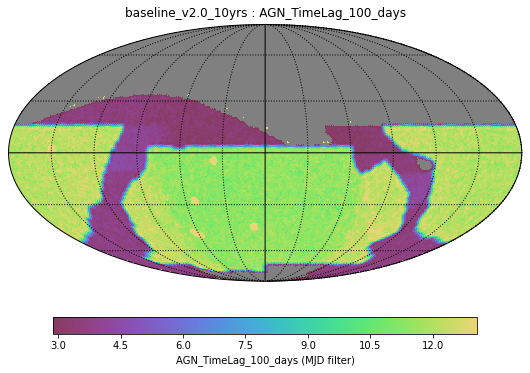

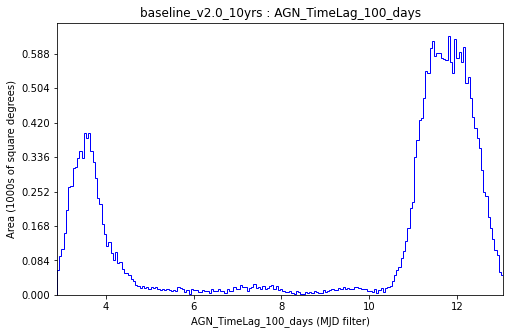

In [6]:
bundle.plot()

In [7]:
bundle.summaryValues

{'Mean': 10.743806871434856,
 'Rms': 46.94465127828596,
 'Median': 11.448901667317953,
 'Max': 3732.228772034882,
 'Min': 2.2034793585557866,
 'N(+3Sigma)': 54,
 'N(-3Sigma)': 0,
 'Count': 32317,
 '25th%ile': 4.448969798922879,
 '75th%ile': 12.037223239828435,
 'AreaThreshold': 27123.452732289275}